In [1]:
from typing import Tuple, Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from tqdm.notebook import tqdm

CONTROLLER_ADDR = '192.168.0.104'

df_X = pd.read_csv('X_test.csv', header=None)

In [2]:
def predict(x: Iterable) -> Tuple[float, float, float, float]:
    resp = requests.get(f'http://{CONTROLLER_ADDR}/predict', params={
        f'x{idx + 1}': xi
        for idx, xi in enumerate(x)
    })
    resp.raise_for_status()

    # noinspection PyTypeChecker
    return tuple(float(y) for idx, y in enumerate(str(resp.text).split(' ')) if idx < 4)


predict((-0.52109855, -0.57133687, -0.481523, -0.5882358, -0.80570453, -0.03607523,
         -0.8392386, -0.8549552, 0.3732829, -0.5899839, 0.38921237, 0.5864193,
         1.0258859, -0.41387412, -0.5701152, -0.6521362, -0.8420634, -0.68346435,
         -0.8151803, -0.668313, 0.6052867, 1.0809759, 0.77627265, -0.77486044,))

(0.01, 0.0, 0.0, 0.99)

In [3]:
indices = [x for x in range(0, len(df_X), len(df_X) // 650)]
df_X = df_X.iloc[indices]
y_pred = np.array([
    predict(x)
    for _, x in tqdm(df_X.iterrows(), total=len(df_X))
], dtype='float64')

  0%|          | 0/651 [00:00<?, ?it/s]

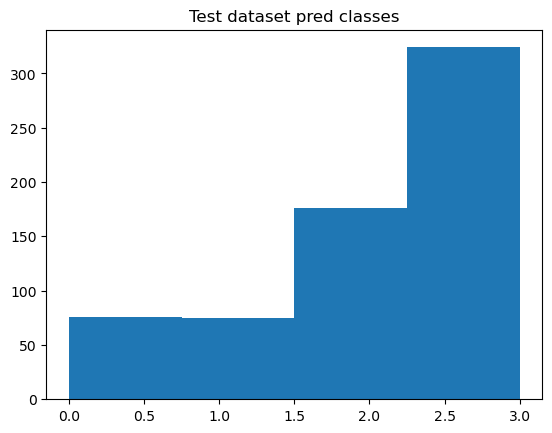

In [4]:
y_pred_cls = np.argmax(y_pred, axis=-1).astype('int32')
plt.title("Test dataset pred classes")
plt.hist(y_pred_cls, bins=4, range=(0, 3))
plt.show()

### Eval on Arduino

In [5]:
df_y = pd.read_csv('y_test.csv', header=None)
df_y = df_y.iloc[indices]
X_test = df_X.to_numpy(dtype='float32')
y_test = df_y.to_numpy(dtype='int32').reshape((-1,))

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred_cls)
print(f'Accuracy: {accuracy:.2f}')

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cls))
print("Classification Report:")
print(classification_report(y_test, y_pred_cls, zero_division=0))

Accuracy: 0.99
Confusion Matrix:
[[ 76   0   0   0]
 [  0  75   0   0]
 [  0   0 172   1]
 [  0   0   4 323]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        75
           2       0.98      0.99      0.99       173
           3       1.00      0.99      0.99       327

    accuracy                           0.99       651
   macro avg       0.99      1.00      0.99       651
weighted avg       0.99      0.99      0.99       651



### Eval on local machine

In [7]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


def predict_local(x):
    input_data = x.reshape(input_details[0]['shape']).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output_data)


y_pred_cls_local = np.array([
    predict_local(X_test[i])
    for i in tqdm(range(len(X_test)), total=len(X_test))
], dtype='int32')

  0%|          | 0/651 [00:00<?, ?it/s]

In [8]:
accuracy = accuracy_score(y_test, y_pred_cls_local)
print(f'Accuracy: {accuracy:.2f}')

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cls_local))
print("Classification Report:")
print(classification_report(y_test, y_pred_cls_local, zero_division=0))

Accuracy: 0.99
Confusion Matrix:
[[ 76   0   0   0]
 [  0  75   0   0]
 [  0   0 172   1]
 [  0   0   4 323]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        75
           2       0.98      0.99      0.99       173
           3       1.00      0.99      0.99       327

    accuracy                           0.99       651
   macro avg       0.99      1.00      0.99       651
weighted avg       0.99      0.99      0.99       651



### Eval samples by API

In [9]:
df = pd.read_csv(fr"E:\datasets\eeg\data1.csv")
df_X = df.drop(columns=[
    'Timestamp', 'Marker tag', 'Unnamed: 31', 'Marker value',
    'Channel 25', 'Channel 26', 'Channel 27', 'Marker timestamp'
])
df_y = df['Marker value']

In [10]:
filtered = df_y[df_y.notna()]
    
def get_sample(_idx):
    _x = df_X.iloc[filtered.index[_idx] + 1800]
    _y = filtered.iloc[_idx]
    return _x, _y

get_sample(2)

(Channel 1    -0.008060
 Channel 2     0.002619
 Channel 3    -0.004173
 Channel 4    -0.011679
 Channel 5    -0.008189
 Channel 6    -0.002232
 Channel 7    -0.007539
 Channel 8    -0.013408
 Channel 9    -0.004882
 Channel 10   -0.015210
 Channel 11   -0.008876
 Channel 12   -0.003341
 Channel 13    0.010716
 Channel 14   -0.005611
 Channel 15   -0.006158
 Channel 16   -0.002520
 Channel 17   -0.001500
 Channel 18    0.004922
 Channel 19   -0.005550
 Channel 20    0.013120
 Channel 21   -0.001731
 Channel 22   -0.005772
 Channel 23   -0.001096
 Channel 24    0.008528
 Name: 14188, dtype: float64,
 'Extension')

In [11]:
from eegmla import ExperimentalArduinoApi

api = ExperimentalArduinoApi(CONTROLLER_ADDR)

def pred_sample(_idx):
    sample_x, sample_y = get_sample(_idx)
    pred = api.predict(*sample_x)
    pred_cls = api.get_label(pred)
    print(f'Sample #{_idx:06d}, pred: {pred_cls}, true: {sample_y}')

pred_sample(2)

Sample #000002, pred: Extension, true: Extension


In [12]:
pred_sample(10)
pred_sample(57)
pred_sample(124)
pred_sample(254)
pred_sample(311)

Sample #000010, pred: Extension, true: Extension
Sample #000057, pred: Pause, true: Pause
Sample #000124, pred: Palm Forward, true: Palm Forward
Sample #000254, pred: Flexion, true: Flexion
Sample #000311, pred: Pause, true: Pause
